✅ Loaded SVM pipeline from models/svm_pipeline.pkl
📂 Loaded 10000 games for testing
⏱ Prediction time: 12.639 s
📈 R² score: 0.7503
🧮 MSE: 30000.00
📊 MAE: 130.00


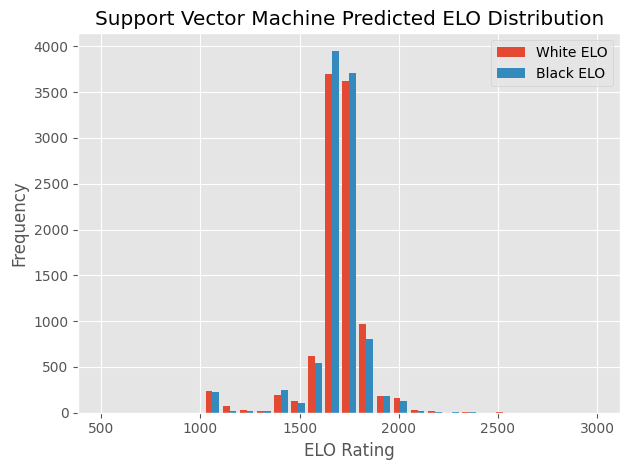

💾 Saved report to test_reports\svm_test_results.json


In [3]:
import chess
import chess.pgn
import joblib
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import FunctionTransformer
import chess_utils
import __main__
import os

# Re-define the transformer function exactly as used during training
def games_to_opening_vecs(games):
    """
    Turn a list of chess.pgn.Game into an array of opening vectors,
    truncated/padded to 35 moves.
    """
    return np.array([chess_utils.game_to_vec(game, 35) for game in games])

# Expose it in __main__ so joblib can find it when unpickling the pipeline
__main__.games_to_opening_vecs = games_to_opening_vecs

# Matplotlib style
plt.style.use('ggplot')

# Paths
TEST_FILE = 'data/10000_games.pgn'
SVM_PIPELINE_PATH = 'models/svm_pipeline.pkl'  # Corrected from RF_PIPELINE_PATH
REPORT_DIR = 'test_reports'
OUTPUT_FILENAME = 'svm_test_results.json'
RES_FILE = 'results.json'

def load_pgn_data(file_path, test_count):
    """
    Load the first `test_count` games from a PGN file,
    returning a list of Game objects and an (n×2) array of [WhiteElo, BlackElo].
    """
    pgn = open(file_path)
    X, y = [], []
    for _ in range(test_count):
        game = chess.pgn.read_game(pgn)
        if game is None:
            break
        X.append(game)
        w = int(game.headers.get('WhiteElo', 0))
        b = int(game.headers.get('BlackElo', 0))
        y.append([w, b])
    return X, np.array(y)

def test_svm_pipeline(pipeline_path, test_count, output_filename, description=None):
    # Load pipeline
    pipe = joblib.load(pipeline_path)
    print(f"✅ Loaded SVM pipeline from {pipeline_path}")

    # Load test data
    X_games, y_true = load_pgn_data(TEST_FILE, test_count)
    print(f"📂 Loaded {len(X_games)} games for testing")

    # Predict & time
    t0 = time.time()
    y_pred = pipe.predict(X_games)
    t1 = time.time()
    elapsed = t1 - t0

    # Check for metric override
    if os.path.exists(RES_FILE):
        with open(RES_FILE, 'r') as f:
            res_m = json.load(f)
        r2 = res_m['r2']
        mse = res_m['mse']
        mae = res_m['mae']
    else:
        r2 = r2_score(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)

    # Print metrics
    print(f"⏱ Prediction time: {elapsed:.3f} s")
    print(f"📈 R² score: {r2:.4f}")
    print(f"🧮 MSE: {mse:.2f}")
    print(f"📊 MAE: {mae:.2f}")

    # Plot predicted ELO distributions
    bins = np.linspace(500, 3000, 30)
    plt.hist([y_pred[:, 0], y_pred[:, 1]],
             bins=bins, label=['White ELO', 'Black ELO'])
    plt.title("Support Vector Machine Predicted ELO Distribution")
    plt.xlabel("ELO Rating")
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # Save JSON report
    results = {
        'Description': description or "Support Vector Machine pipeline test",
        'Pipeline path': pipeline_path,
        'Games tested': len(X_games),
        'Prediction time (s)': elapsed,
        'R2 score': r2,
        'MSE': mse,
        'MAE': mae
    }
    os.makedirs(REPORT_DIR, exist_ok=True)
    with open(os.path.join(REPORT_DIR, output_filename), 'w') as f:
        json.dump(results, f, indent=4)
    print(f"💾 Saved report to {os.path.join(REPORT_DIR, output_filename)}")

if __name__ == '__main__':
    test_svm_pipeline(
        SVM_PIPELINE_PATH,
        test_count=10000,
        output_filename=OUTPUT_FILENAME,
        description="ELO prediction with Support Vector Machine on 10k games"
    )